In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import talib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional

In [3]:
def mysql_query(sql):
    endpoint = 'capstonedb.c2exfkakcxag.us-east-1.rds.amazonaws.com'
    username = 'admin'
    password = 'abcd1234'
    database_name = 'stock'

    # connection
    connection = pymysql.connect(host=endpoint, user=username,
                                password=password, database=database_name)

    cursor = connection.cursor()
    cursor.execute(sql)

    rows = cursor.fetchall()

    #for row in rows:
        #print("{0} {1} {2}".format(row[0], row[1], row[2]))
    #    print(row)
    #    break
    
    cursor.close()
    connection.close()
    
    return rows


# Load Data

In [4]:
sql = 'select * from stock.t_stock_daily where ticket = "AMD" order by trade_date asc'
rows = mysql_query(sql)
stock_df = pd.DataFrame(rows, columns=['trade_date', 'open', 'high', 'low', 'close', 'volume', 
                            'dividends', 'stock_splits', 'ticket', 'sector'])
stock_df.head(3)

,trade_date,open,high,low,close,volume,dividends,stock_splits,ticket,sector
0,2019-04-05,29.639999,29.690001,28.799999,28.980000,65662700.0,0.0,0.0,AMD,Technology
1,2019-04-08,28.690001,28.950001,28.180000,28.530001,58002500.0,0.0,0.0,AMD,Technology
2,2019-04-09,28.240000,28.379999,27.190001,27.240000,75539800.0,0.0,0.0,AMD,Technology


# Selected Technical Indicators 

- n: For example n = 10

- 1. Simple n-day moving average = (𝐶t + ... 𝐶t-n+1) / n
- 2. Weighted n-day moving average = (𝑛∗𝐶𝑡+(𝑛−1)∗𝐶𝑡−1+⋯+𝐶𝑡−𝑛+1) / (𝑛+(𝑛−1)+⋯+1)
- 3. Relative strength index (RSI) = https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
- 4. Price rate = ( open(t) - open(t-1) ) / ( max(high in n) - min(low in n) )
- 5. Volume rate = ( v(t) - v(t-1) ) / ( max(v in n) - min(v in n) )
- 6. Commodity Channel Index = https://school.stockcharts.com/doku.php?id=technical_indicators:commodity_channel_index_cci
- 7. Force Index = https://school.stockcharts.com/doku.php?id=technical_indicators:force_index
- 8. Rate of Change (ROC) = https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum
- 9. Bollinger Bands = https://school.stockcharts.com/doku.php?id=technical_indicators:bollinger_bands
- 10. Momentum = 𝐶𝑡 − 𝐶𝑡−𝑛+1

𝐶𝑡 is the closing price at time t

open(t) is the opening price at time t

v(t) is the volume at time t

In [5]:
# Simple Moving Average
# https://school.stockcharts.com/doku.php?id=technical_indicators:moving_averages
def SMA(data, ndays):
    SMA = pd.Series(data['close'].rolling(ndays, min_periods = 1).mean(), name = 'sma_' + str(ndays))
    data = data.join(SMA)
    return data

# Weighted n-day moving average
def WMA(data, ndays):
    name = 'wma_' + str(ndays)
    data[name] = talib.RSI(data['close'], timeperiod=ndays)
    return data

# Relative strength index (RSI)
def RSI(data, ndays):
    name = 'rsi_' + str(ndays)
    data[name] = talib.RSI(data['close'], timeperiod=ndays)
    return data

# ( open(t) - open(t-1) ) / ( max(high in ndays) - min(low in ndays) )
def p_rate_period_n(data, ndays):
    ot = data['open'].diff(1)
    max_high = data['high'].rolling(ndays, min_periods = 1).max()
    min_low = data['low'].rolling(ndays, min_periods = 1).min()
    
    p_open_ = pd.Series(ot / (max_high - min_low), name='p_rate_period_' + str(ndays))
    data = data.join(p_open_)
    return data


# ( v(t) - v(t-1) ) / ( max(v in ndays) - min(v in ndays) )
def v_rate_period_n(data, ndays):
    ot = data['volume'].diff(1)
    max_high = data['volume'].rolling(ndays, min_periods = 1).max()
    min_low = data['volume'].rolling(ndays, min_periods = 1).min()
    
    p_open_ = pd.Series(ot / (max_high - min_low), name='v_rate_period_' + str(ndays))
    data = data.join(p_open_)
    return data

# Commodity Channel Index
def CCI(data, ndays):
    name = 'cci_' + str(ndays)
    data[name] = talib.CCI(data['high'], data['low'], data['close'], timeperiod=ndays)
    return data

# Force Index 
def ForceIndex(data, ndays):
    FI = pd.Series(data['close'].diff(ndays) * data['volume'], name = 'force_index_' + str(ndays))
    data = data.join(FI)
    return data

# Rate of Change (ROC)
def ROC(data, ndays):
    name = 'roc_' + str(ndays)
    data[name] = talib.ROC(data['close'], timeperiod=ndays)
    return data

# Bollinger Bands
def BollingerBands(data, ndays, col_name='close'):
    MA = data[col_name].rolling(ndays, min_periods = 1).mean()
    SD = data[col_name].rolling(ndays, min_periods = 1).std()
    
    b1 = MA + (2 * SD)
    B1 = pd.Series(b1, name = 'bband_upper_' + str(ndays))
    data = data.join(B1)
    
    b2 = MA - (2 * SD)
    B2 = pd.Series(b2, name = 'bband_lower_' + str(ndays))
    data = data.join(B2) 
    return data

def Momentum(data, ndays):
    name = 'mom_' + str(ndays)
    data[name] = talib.MOM(data['close'], timeperiod=ndays)
    return data


def add_indicators(data, ndays = 10):
    data = SMA(data, ndays)
    data = WMA(data, ndays)
    data = RSI(data, ndays)
    data = p_rate_period_n(data, ndays)
    data = v_rate_period_n(data, ndays)
    data = CCI(data, ndays)
    data = ForceIndex(data, ndays)
    data = ROC(data, ndays)
    data = BollingerBands(data, ndays)
    data = Momentum(data, ndays)
    
    return data

In [6]:
def indicator_names(ndays):
    arr = ['trade_date', 'close', 'open', 'high', 'low', 'volume',
           'sma_' + str(ndays), 'wma_' + str(ndays), 'rsi_' + str(ndays), 'p_rate_period_' + str(ndays), 
           'v_rate_period_' + str(ndays), 'cci_' + str(ndays), 'force_index_' + str(ndays), 'roc_' + str(ndays), 
           'bband_upper_' + str(ndays), 'bband_lower_' + str(ndays), 'mom_' + str(ndays)]

    return arr
    
def get_model_df(data, ndays):
    df_ = add_indicators(data, ndays)
    df_ = df_.iloc[ndays:, :]
    print(df_.shape)
    return df_[indicator_names(ndays)]



In [7]:
get_model_df(stock_df.copy(), 10)

(755, 21)


,trade_date,close,open,high,low,volume,sma_10,wma_10,rsi_10,p_rate_period_10,v_rate_period_10,cci_10,force_index_10,roc_10,bband_upper_10,bband_lower_10,mom_10
10,2019-04-22,28.180000,27.620001,28.230000,27.389999,36477300.0,27.785000,41.453000,41.453000,0.010050,-0.087132,37.958851,-2.918181e+07,-2.760522,28.556853,27.013148,-0.799999
11,2019-04-23,27.969999,28.180000,28.490000,27.790001,41777500.0,27.729000,39.484396,39.484396,0.366013,0.135685,134.315839,-2.339546e+07,-1.962851,28.320905,27.137095,-0.560001
12,2019-04-24,28.459999,28.100000,28.850000,27.930000,51784700.0,27.851000,46.118390,46.118390,-0.042328,0.358799,183.225794,6.317730e+07,4.478705,28.495529,27.206471,1.219999
13,2019-04-25,27.660000,28.670000,28.860001,27.360001,57329700.0,27.834000,38.468368,38.468368,0.300000,0.265917,30.647736,-9.746053e+06,-0.610852,28.489859,27.178141,-0.170000
14,2019-04-26,27.879999,27.660000,27.900000,27.049999,48827900.0,27.843000,41.436641,41.436641,-0.531579,-0.407713,-71.428685,4.394425e+06,0.323851,28.498645,27.187355,0.089998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,2022-04-18,93.329002,92.029999,94.730003,91.639999,41467218.0,103.846400,29.058364,29.058364,-0.186306,-0.284006,-77.173761,-1.115924e+09,-22.381068,127.284519,80.408280,-26.910995
761,2022-04-19,96.290001,93.385002,97.070000,92.839996,41025192.0,101.152399,35.525090,35.525090,0.039818,-0.003948,-51.614305,-1.105219e+09,-21.861561,120.529660,81.775139,-26.940002
762,2022-04-20,94.279999,97.839996,97.910004,93.889999,32518755.0,98.658399,33.239721,33.239721,0.180073,-0.074301,-43.376317,-8.110178e+08,-20.919311,113.616374,83.700425,-24.940002
763,2022-04-21,91.970001,95.160004,96.230003,91.389999,35292667.0,96.921400,30.716445,30.716445,-0.133799,0.034982,-64.168388,-6.130335e+08,-15.886223,110.319306,83.523494,-17.369995


# Train and Evaluate Models

In [50]:
ndays_arr = [10, 20, 50, 100]
back_look_arr = [10, 20, 50, 100]

In [51]:
def train_1hidden_LSTM_model(x_train, y_train):
    """
    Simple LSTM with 1 hidden LSTM layers
    """
    #model = Sequential()
    #model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    #model.add(Dense(1))
    #model.compile(optimizer='adam', loss='mse')
    
    # LSTM
    model = Sequential()
    # input_shape=(timesteps, data_dim)
    model.add(LSTM(128, return_sequences=False, input_shape= (x_train.shape[1], x_train.shape[2])))
    #model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1))
    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # train the model
    model.fit(x_train, y_train, batch_size=1, epochs=3)
    
    return model

def train_2hidden_LSTM_model(x_train, y_train):
    """
    Stacked LSTM with 2 hidden LSTM layers
    """
    
    # LSTM
    model = Sequential()
    # input_shape=(timesteps, data_dim)
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # train the model
    model.fit(x_train, y_train, batch_size=1, epochs=3)
    
    return model

def train_bidirectional_LSTM_model(x_train, y_train):
    """
    Bidirectional LSTM
    """
    
    # LSTM
    model = Sequential()
    # input_shape=(timesteps, data_dim)
    model.add(Bidirectional(LSTM(50), input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # train the model
    model.fit(x_train, y_train, batch_size=1, epochs=3)
    
    return model

def forecost_LSTM_model(model, x_valid, y_valid, train_unscaled, valid_unscaled):
    # forecast stock price
    closing_price = model.predict(x_valid)
    
    # Scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(pd.DataFrame(valid_unscaled['close'].values))
    
    # inverse scaler
    closing_price = scaler.inverse_transform(closing_price)
    y_valid = scaler.inverse_transform([y_valid])
    # print(y_valid)
    # print(closing_price)
    
    # get RMSE
    rmse = np.sqrt(np.mean(np.power((y_valid - closing_price), 2)))
    print("rmse = {}".format(str(rmse)))
    
    # get earn_pct
    earn_pct = cal_earn_pct(y_valid, closing_price)
    print("earn_pct = {}".format(str(earn_pct)))
    
    predict_dict_data = {
        'Predictions': closing_price.reshape(1,-1)[0],
        'Close': y_valid[0]
    }
    return rmse, predict_dict_data, earn_pct


# real_closes is np.array, predicted_closes is np.array
def cal_earn_pct(real_closes, predicted_closes):
    real_closes_df = pd.DataFrame(real_closes[0], columns=['real_close'])
    p_closes_df = pd.DataFrame(predicted_closes, columns=['close'])
    
    predicted_closes_df = pd.concat([real_closes_df,p_closes_df], axis=1)
    
    start_cash = 1000000
    
    init_cash = 1000000
    hold_number_stocks = 0
    
    symbol = 'income'
    bought = {symbol:'OUT'}
    trade_lst = []
    sold_lst = []
    # amd_df['direction'] = np.sign(amd_df["close"].pct_change()*100.0)
    # predicted_closes_df = pd.DataFrame([predicted_closes], columns=['close'])
    
    
    predicted_closes_df['predict_direction'] = np.sign(predicted_closes_df["close"].pct_change()*100.0)
    
    for index, row in predicted_closes_df.iterrows():
        
        change_pct = 0.0
        if trade_lst:
            last_one = trade_lst[-1]
            
            change_pct = (row['real_close'] / last_one[0] - 1) * 100
                
        if row['predict_direction'] > 0.0 and bought[symbol] == 'OUT':
            
            trade_lst.append(row)
            
            number_stocks = init_cash // row['real_close']
            hold_number_stocks = number_stocks

            spend = number_stocks * row['real_close']
            #print(init_cash)
            init_cash -= spend


            bought[symbol] = 'LONG'
            continue
            
        elif bought[symbol] == 'LONG' and ( (row['predict_direction'] < 0.0) or change_pct > 1.0 or change_pct < -1.0 ):
            sold_lst.append(row)

            sold = hold_number_stocks * row['real_close']
            #print('sold:' + str(sold))
            #print('init_cash:' + str(init_cash))
            init_cash += sold
            #print('---' + str(init_cash))

            hold_number_stocks = 0
            bought[symbol] = 'OUT'
            continue

    
    cash = init_cash + hold_number_stocks * trade_lst[-1][0]
    print(cash)
    earn_pct = (cash / start_cash - 1) * 100
    print(earn_pct)
    return round(earn_pct, 2)
    
    
def split_train_test_sets(amd_df, ndays, back_look_time_steps, training_data_len):
    # back look time steps
    time_stamp = back_look_time_steps

    # get train and test sets
    ind_names = indicator_names(ndays)

    # get features without trade_date
    amd_stock = amd_df[ind_names[1:]]  #  close, sma_10, wma_10, rsi_10

    # un scaled data
    train = amd_stock[0:training_data_len + time_stamp]
    valid = amd_stock[training_data_len - time_stamp:]
    
    train_unscaled = amd_stock[0:training_data_len + time_stamp]
    valid_unscaled = amd_stock[training_data_len - time_stamp:]

    # Scaler
    scaler = MinMaxScaler(feature_range=(0, 1))  
    scaled_data = scaler.fit_transform(train)
    x_train, y_train = [], []


    # train set
    #print(scaled_data.shape)
    #print(scaled_data[1, 0]) # 1 row, close
    for i in range(time_stamp, len(train)):
        x_train.append(scaled_data[i - time_stamp:i])
        y_train.append(scaled_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # valid set
    scaled_data = scaler.fit_transform(valid)
    x_valid, y_valid = [], []
    for i in range(time_stamp, len(valid)):
        x_valid.append(scaled_data[i - time_stamp:i])
        y_valid.append(scaled_data[i, 0])

    x_valid, y_valid = np.array(x_valid), np.array(y_valid)

    #print(x_train.shape)
    #print(x_valid.shape)
    
    return x_train, y_train, x_valid, y_valid, train_unscaled, valid_unscaled
    
def start_2hidden_layers(data_df):
    
    results = []
    
    for ndays in ndays_arr:
        
        # add indicators
        amd_df = get_model_df(data_df, ndays)
        
        # get train set rows
        training_data_len = int(np.ceil( len(amd_df) * .8 ))
        print("train_length:{}, test_length:{}".format(training_data_len, len(amd_df) - training_data_len))
        
        # use different back_look_steps to train LSTM models
        for back_look_time_steps in back_look_arr:
            
            x_train, y_train, x_valid, y_valid, train_unscaled, valid_unscaled = split_train_test_sets(amd_df, ndays, back_look_time_steps, training_data_len)
            
            print("indicator_ndays = {}, back_look_time_steps = {}. Training start".format(str(ndays), str(back_look_time_steps)))
            
            # train model
            model = train_2hidden_LSTM_model(x_train, y_train)
            
            # forecost
            rmse, predict_dict_data, earn_pct = forecost_LSTM_model(model, x_valid, y_valid, train_unscaled, valid_unscaled)
            
            result_dic = {"model_type":"2_hidden_layers", "indicator_ndays":ndays, "back_look_time_steps":back_look_time_steps, 
                          "rmse":rmse, "predict_dict_data":predict_dict_data, "earn_pct":earn_pct}
            
            results.append(result_dic)
    
    
    return results

def start_1hidden_layers(data_df):
    
    results = []
    
    for ndays in ndays_arr:
        
        # add indicators
        amd_df = get_model_df(data_df, ndays)
        
        # get train set rows
        training_data_len = int(np.ceil( len(amd_df) * .8 ))
        print("train_length:{}, test_length:{}".format(training_data_len, len(amd_df) - training_data_len))
        
        # use different back_look_steps to train LSTM models
        for back_look_time_steps in back_look_arr:
            
            x_train, y_train, x_valid, y_valid, train_unscaled, valid_unscaled = split_train_test_sets(amd_df, ndays, back_look_time_steps, training_data_len)
            
            print("indicator_ndays = {}, back_look_time_steps = {}. Training start".format(str(ndays), str(back_look_time_steps)))
            
            # train model
            model = train_1hidden_LSTM_model(x_train, y_train)
            
            # forecost
            rmse, predict_dict_data, earn_pct = forecost_LSTM_model(model, x_valid, y_valid, train_unscaled, valid_unscaled)
            
            result_dic = {"model_type":"1_hidden_layers", "indicator_ndays":ndays, "back_look_time_steps":back_look_time_steps, 
                          "rmse":rmse, "predict_dict_data":predict_dict_data, "earn_pct":earn_pct}
            
            results.append(result_dic)
    
    
    return results


def start_bidirectional_LSTM(data_df):
    
    results = []
    
    for ndays in ndays_arr:
        
        # add indicators
        amd_df = get_model_df(data_df, ndays)
        
        # get train set rows
        training_data_len = int(np.ceil( len(amd_df) * .8 ))
        print("train_length:{}, test_length:{}".format(training_data_len, len(amd_df) - training_data_len))
        
        # use different back_look_steps to train LSTM models
        for back_look_time_steps in back_look_arr:
            
            x_train, y_train, x_valid, y_valid, train_unscaled, valid_unscaled = split_train_test_sets(amd_df, ndays, back_look_time_steps, training_data_len)
            
            print("indicator_ndays = {}, back_look_time_steps = {}. Training start".format(str(ndays), str(back_look_time_steps)))
            
            # train model
            model = train_bidirectional_LSTM_model(x_train, y_train)
            
            # forecost
            rmse, predict_dict_data, earn_pct = forecost_LSTM_model(model, x_valid, y_valid, train_unscaled, valid_unscaled)
            
            result_dic = {"model_type":"bidirectional_LSTM", "indicator_ndays":ndays, "back_look_time_steps":back_look_time_steps, 
                          "rmse":rmse, "predict_dict_data":predict_dict_data, "earn_pct":earn_pct}
            
            results.append(result_dic)
    
    
    return results


rmse_results_bidirectional = start_bidirectional_LSTM(stock_df.copy())
rmse_results1 = start_1hidden_layers(stock_df.copy())
rmse_results2 = start_2hidden_layers(stock_df.copy())

(755, 21)
train_length:604, test_length:151
indicator_ndays = 10, back_look_time_steps = 10. Training start
Epoch 1/3
604/604 [==============================] - 2s 3ms/step - loss: 0.0032
Epoch 2/3
604/604 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 3/3
604/604 [==============================] - 2s 3ms/step - loss: 0.0013
rmse = 24.06471945611501
904741.1367492675
-9.525886325073252
earn_pct = -9.53
indicator_ndays = 10, back_look_time_steps = 20. Training start
Epoch 1/3
604/604 [==============================] - 3s 5ms/step - loss: 0.0043
Epoch 2/3
604/604 [==============================] - 3s 5ms/step - loss: 0.0014
Epoch 3/3
604/604 [==============================] - 3s 4ms/step - loss: 0.0015
rmse = 24.349172015910558
973046.9392547607
-2.695306074523929
earn_pct = -2.7
indicator_ndays = 10, back_look_time_steps = 50. Training start
Epoch 1/3
604/604 [==============================] - 6s 9ms/step - loss: 0.0025
Epoch 2/3
604/604 [===========================

596/596 [==============================] - 2s 3ms/step - loss: 0.0033
Epoch 2/3
596/596 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 3/3
596/596 [==============================] - 2s 3ms/step - loss: 9.6719e-04
rmse = 24.50596575859691
906204.1930999757
-9.379580690002431
earn_pct = -9.38
indicator_ndays = 20, back_look_time_steps = 20. Training start
Epoch 1/3
596/596 [==============================] - 3s 4ms/step - loss: 0.0036
Epoch 2/3
596/596 [==============================] - 3s 4ms/step - loss: 0.0013
Epoch 3/3
596/596 [==============================] - 3s 5ms/step - loss: 9.7115e-04
rmse = 25.147535993912363
1018792.4876327518
1.8792487632751875
earn_pct = 1.88
indicator_ndays = 20, back_look_time_steps = 50. Training start
Epoch 1/3
596/596 [==============================] - 6s 9ms/step - loss: 0.0042
Epoch 2/3
596/596 [==============================] - 5s 9ms/step - loss: 9.0266e-04
Epoch 3/3
596/596 [==============================] - 5s 9ms/step - loss

572/572 [==============================] - 3s 5ms/step - loss: 0.0016A: 0s
rmse = 24.949482522392863
963863.5330657954
-3.613646693420458
earn_pct = -3.61
indicator_ndays = 50, back_look_time_steps = 20. Training start
Epoch 1/3
572/572 [==============================] - 5s 9ms/step - loss: 0.0056
Epoch 2/3
572/572 [==============================] - 5s 9ms/step - loss: 0.0024
Epoch 3/3
572/572 [==============================] - 5s 9ms/step - loss: 0.0016
rmse = 24.143392670898425
1124084.1007385256
12.408410073852561
earn_pct = 12.41
indicator_ndays = 50, back_look_time_steps = 50. Training start
Epoch 1/3
572/572 [==============================] - 10s 18ms/step - loss: 0.0034
Epoch 2/3
572/572 [==============================] - 12s 20ms/step - loss: 0.0016
Epoch 3/3
572/572 [==============================] - 12s 21ms/step - loss: 0.0018
rmse = 23.884188907129985
1044656.0073013308
4.46560073013309
earn_pct = 4.47
indicator_ndays = 50, back_look_time_steps = 100. Training start
Epoch 1

# Show the Results

In [52]:
rmse_df = pd.DataFrame(rmse_results_bidirectional + rmse_results1 + rmse_results2)
rmse_df = rmse_df[['model_type', 'indicator_ndays', 'back_look_time_steps', 'rmse', 'earn_pct']]
rmse_df.sort_values(by=['rmse'])

,model_type,indicator_ndays,back_look_time_steps,rmse,earn_pct
14,bidirectional_LSTM,100,50,20.446348,-14.75
46,2_hidden_layers,100,50,20.471462,2.09
10,bidirectional_LSTM,50,50,21.257105,8.33
44,2_hidden_layers,100,10,21.284290,-5.34
28,1_hidden_layers,100,10,21.561937,-21.84
15,bidirectional_LSTM,100,100,21.945917,-8.82
13,bidirectional_LSTM,100,20,22.088998,-10.70
12,bidirectional_LSTM,100,10,22.240560,2.48
29,1_hidden_layers,100,20,22.351155,-0.51
45,2_hidden_layers,100,20,22.518059,0.94


In [54]:
rmse_df.sort_values(by=['earn_pct'], ascending=False)

,model_type,indicator_ndays,back_look_time_steps,rmse,earn_pct
41,2_hidden_layers,50,20,24.143393,12.41
10,bidirectional_LSTM,50,50,21.257105,8.33
35,2_hidden_layers,10,100,23.905084,5.49
42,2_hidden_layers,50,50,23.884189,4.47
7,bidirectional_LSTM,20,100,24.323449,3.01
12,bidirectional_LSTM,100,10,22.240560,2.48
22,1_hidden_layers,20,50,23.936863,2.13
46,2_hidden_layers,100,50,20.471462,2.09
21,1_hidden_layers,20,20,25.147536,1.88
26,1_hidden_layers,50,50,22.522669,1.14


# Plot the data with the lowest RMSE

In [56]:
rmse_all_df = pd.DataFrame(rmse_results_bidirectional + rmse_results1 + rmse_results2)

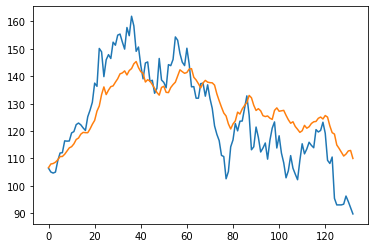

In [57]:
# Pring the lowes rmse plot
data_pd = pd.DataFrame(rmse_all_df.sort_values(by=['rmse']).iloc[:1]["predict_dict_data"].values[0])

plt.plot(data_pd[['Close', 'Predictions']])
plt.show()

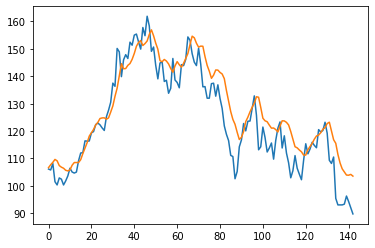

In [58]:
# Pring the highest earn_pct plot
data_pd = pd.DataFrame(rmse_all_df.sort_values(by=['earn_pct'], ascending=False).iloc[:1]["predict_dict_data"].values[0])

plt.plot(data_pd[['Close', 'Predictions']])
plt.show()